# Goals:

1. Implement LangChain's Semamtic chunking
2. Re-evaluate if performance is worse.
3. Perhaps chunks of value are too large? In which case drop threshold cut.

| LangChain | SemanticChunker | 0 | 0 | text-embedding-3-large | 0.073 ± 0.104 | 0.824 ± 0.379 | 0.079 ± 0.097 | 0.998 ± 0.032 |
It's worse.

Investigation of LangChain's Semantic Chunking

In [1]:
import chromadb.utils.embedding_functions as embedding_functions
import chromadb
import os

chroma_client = chromadb.PersistentClient(path="../../data/chroma_db")
OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')
openai_ef = embedding_functions.OpenAIEmbeddingFunction(
                api_key=OPENAI_API_KEY,
                model_name="text-embedding-3-large"
            )

collection_name = "auto_chunk"

collection = chroma_client.get_collection(collection_name, embedding_function=openai_ef)

In [2]:
import tiktoken

# Count the number of tokens in each page_content
def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string, disallowed_special=()))
    return num_tokens

In [3]:
docs = collection.get()

In [7]:
docs.keys()

dict_keys(['ids', 'embeddings', 'metadatas', 'documents', 'uris', 'data'])

In [4]:
import numpy as np
token_counts = np.array([num_tokens_from_string(doc) for doc in docs['documents']])

# corpus_id_flags = [1 if metadata['corpus_id'] == 'state_of_the_union' else 0 for metadata in docs['metadatas']]

# token_counts = [token_counts[i] for i, flag in enumerate(corpus_id_flags) if flag]
# metadatas = [docs['metadatas'][i] for i, flag in enumerate(corpus_id_flags) if flag]
# texts = [docs['documents'][i] for i, flag in enumerate(corpus_id_flags) if flag]


# For Default LangChain (95th Percentile cut off)

Mean Token Count: 116.91150442477876
Median Token Count: 100.0
Standard Deviation of Token Count: 67.43854068930524
Maximum Token Count: 467
Minimum Token Count: 19


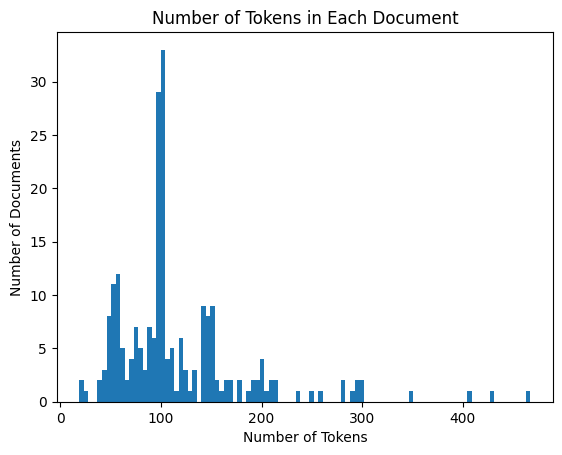

In [5]:
import numpy as np  
import matplotlib.pyplot as plt

# Calculate and print the mean, median, standard deviation, maximum and minimum of the token counts
mean_token_count = np.mean(token_counts)
median_token_count = np.median(token_counts)
std_token_count = np.std(token_counts)
max_token_count = np.max(token_counts)
min_token_count = np.min(token_counts)

print(f"Mean Token Count: {mean_token_count}")
print(f"Median Token Count: {median_token_count}")
print(f"Standard Deviation of Token Count: {std_token_count}")
print(f"Maximum Token Count: {max_token_count}")
print(f"Minimum Token Count: {min_token_count}")


plt.hist(token_counts, bins=100)
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Documents')
plt.title('Number of Tokens in Each Document')
plt.show()

In [6]:
index_max_token_count = np.argmax(token_counts)
print(f"Index of Maximum Token Count: {index_max_token_count}")


Index of Maximum Token Count: 107


In [7]:
docs['metadatas'][index_max_token_count]

{'corpus_id': 'wikitexts', 'end_index': 101159, 'start_index': 99074}

In [8]:
docs['documents'][index_max_token_count]

'= = Background and release = = " There \'s Got to Be a Way " was written by Mariah Carey and Ric Wake for Carey \'s self @-@ titled debut studio album ( 1990 ) . It was written during Carey and Wake \'s first recording session together . They composed four songs , but only " There \'s Got to Be a Way " was chosen for the final track listing . Co @-@ produced by Wake and Narada Michael Walden , it appears as the second of ten songs on the track listing . The track was recorded and engineered by Bob <unk> at Cove City Sound Studios and The Power Station , both located in New York City . He was assisted by Dana Jon Chappelle . It was mixed by David Frazer at Tarpan Studios in San Rafael . The keyboards , bass and rhythm engineering was carried out by Louis Biancaniello , while Joe Franco performed the percussion , Vernon " Ice " Black played the guitar , and Rich Tancredo also performing on the keyboards . Walter Afanasieff played the synth horns . Carey provided her own background vocal

In [9]:
texts[index_max_token_count]

NameError: name 'texts' is not defined

In [23]:
metadatas[index_max_token_count]

{'corpus_id': 'state_of_the_union', 'end_index': 43747, 'start_index': 37615}

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter, TokenTextSplitter
import tiktoken

# Count the number of tokens in each page_content
def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string, disallowed_special=()))
    return num_tokens

splitter = RecursiveCharacterTextSplitter(
            chunk_size=25,
            chunk_overlap=0,
            length_function=num_tokens_from_string
        )

In [6]:
with open('../data/chatlogs.md', 'r') as file:
    data = file.read()

print(num_tokens_from_string(data))

26649


In [21]:
with open('../data/state_of_the_union.md', 'r') as file:
    data = file.read()

chunks = splitter.split_text(data)
print(len(chunks))

588


In [2]:
import chromadb.utils.embedding_functions as embedding_functions
import chromadb
import os

chroma_client = chromadb.PersistentClient(path="../../data/chroma_db")
OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')
openai_ef = embedding_functions.OpenAIEmbeddingFunction(
                api_key=OPENAI_API_KEY,
                model_name="text-embedding-3-large"
            )

collection_name = "auto_chunk"

collection = chroma_client.get_collection(collection_name, embedding_function=openai_ef)

In [3]:
all_docs = collection.get()

tokens = [num_tokens_from_string(x) for x in all_docs['documents']]

import numpy as np

mean_tokens = np.mean(tokens)
median_tokens = np.median(tokens)
min_tokens = np.min(tokens)
max_tokens = np.max(tokens)
std_tokens = np.std(tokens)

print(f"Mean: {mean_tokens}")
print(f"Median: {median_tokens}")
print(f"Min: {min_tokens}")
print(f"Max: {max_tokens}")
print(f"Standard Deviation: {std_tokens}")


Mean: 221.35457627118643
Median: 191.0
Min: 1
Max: 851
Standard Deviation: 168.8979785462924


In [35]:
retrievals = collection.query(query_texts=["Hello?", "How are you?"], n_results=5)

In [41]:
retrievals['metadatas']

def get_retrieval_meta_str_inst(metadatas: dict) -> list:
    """Returns a list of strings that represent the metadata of the retrievals."""
    retrieval_meta_str_list = [f"{metadata['corpus_id']},{metadata['start_index']},{metadata['end_index']}" for metadata in metadatas]
    retrieval_meta_str = "\n".join(retrieval_meta_str_list)
    return retrieval_meta_str

retrieval_meta_str_list = [get_retrieval_meta_str_inst(x) for x in retrievals['metadatas']]

In [42]:
retrieval_meta_str_list

['state_of_the_union,32969,34809\nstate_of_the_union,25997,27691\nstate_of_the_union,42465,44323\nchatlogs,28192,30508\nstate_of_the_union,0,1889',
 'pubmed,63244,65039\npubmed,7066,8800\npubmed,61825,63244\npubmed,10724,12488\npubmed,3445,5308']

In [45]:
import re
from statistics import mean

# Function to parse the log data
def parse_log(data):
    entries = re.split(r'Index: \d+', data)
    entries = [entry.strip() for entry in entries if entry.strip()]
    triplets = []
    for entry in entries:
        strings = entry.split(':')
        strings = [s.strip() for s in strings if s.strip()]
        triplet = [s.split('\n') for s in strings]
        triplets.append(triplet)
    return triplets

# Function to find differing lines and calculate the average difference
def calculate_average_differences(triplets):
    differences = []
    for triplet in triplets:
        for i in range(5):  # Assuming each string has exactly 5 lines
            line1 = triplet[0][i]
            line2 = triplet[1][i]
            line3 = triplet[2][i]
            if line1 != line2 or line1 != line3:
                _, start1, end1 = map(int, line1.split(',')[1:])
                _, start2, end2 = map(int, line2.split(',')[1:])
                _, start3, end3 = map(int, line3.split(',')[1:])
                diff1 = end1 - start1
                diff2 = end2 - start2
                diff3 = end3 - start3
                differences.append(mean([abs(diff1 - diff2), abs(diff1 - diff3), abs(diff2 - diff3)]))
    return mean(differences) if differences else 0

# Input log data
log_data = """Index: 22
String 1: state_of_the_union,27691,29550
state_of_the_union,29550,31157
state_of_the_union,31157,32969
state_of_the_union,34809,36628
state_of_the_union,18563,20332
String 2: state_of_the_union,27691,29550
state_of_the_union,29550,31157
state_of_the_union,31157,32969
state_of_the_union,34809,36628
state_of_the_union,16734,18563
String 3: state_of_the_union,27691,29550
state_of_the_union,29550,31157
state_of_the_union,31157,32969
state_of_the_union,34809,36628
state_of_the_union,16734,18563
Index: 23
String 1: state_of_the_union,7413,9314
state_of_the_union,42465,44323
state_of_the_union,9314,11282
state_of_the_union,34809,36628
state_of_the_union,16734,18563
String 2: state_of_the_union,7413,9314
state_of_the_union,42465,44323
state_of_the_union,9314,11282
state_of_the_union,34809,36628
state_of_the_union,14959,16734
String 3: state_of_the_union,7413,9314
state_of_the_union,42465,44323
state_of_the_union,9314,11282
state_of_the_union,34809,36628
state_of_the_union,14959,16734"""

# Parse the log and calculate the average differences
triplets = parse_log(log_data)
average_difference = calculate_average_differences(triplets)

print(f"Average difference in the start and end index lengths for differing lines: {average_difference}")


ValueError: not enough values to unpack (expected 3, got 2)

In [1]:
import chromadb.utils.embedding_functions as embedding_functions
import chromadb
import os

chroma_client = chromadb.PersistentClient(path="../../data/chroma_db")
OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')
# openai_ef = embedding_functions.OpenAIEmbeddingFunction(
#                 api_key=OPENAI_API_KEY,
#                 model_name="text-embedding-3-large"
#             )

# collection_name = "questions_openai_large"
collection_name = "questions_BERT"

collection = chroma_client.create_collection(collection_name)
# collection = chroma_client.create_collection(collection_name, embedding_function=openai_ef)

In [2]:
import pandas as pd

questions_df = pd.read_csv('../data/questions_df.csv')

In [3]:
import json

questions_df['references'] = questions_df['references'].apply(json.loads)

In [4]:
docs = questions_df['question'].tolist()
metas = []
ids = []
for _, row in questions_df.iterrows():
    metas.append({'id': row.name, 'corpus_id': row['corpus_id']})
    ids.append(str(row.name))


collection.add(
    documents=docs,
    metadatas=metas,
    ids=ids
)

In [60]:
questions_collection = chroma_client.get_collection("auto_chunk", embedding_function=openai_ef)

In [5]:
question_db = collection.get(include=['embeddings'])


In [7]:
len(question_db['embeddings'][0])

384

In [66]:
# Convert ids to integers for sorting
question_db['ids'] = list(map(int, question_db['ids']))

# Create a sorted list of tuples (id, embedding)
sorted_id_embeddings = sorted(zip(question_db['ids'], question_db['embeddings']))

# Unzip the sorted list into two lists: sorted_ids and sorted_embeddings
sorted_ids, sorted_embeddings = zip(*sorted_id_embeddings)

# Update question_db with the sorted lists
# question_db['ids'] = list(sorted_ids)

sorted_embeddings = list(sorted_embeddings)

In [69]:
docs[0]

"What significant regulatory changes and proposals has President Biden's administration implemented or announced regarding fees and pricing transparency?"